# Data Analysis: Fraud Detection for Automobile Claims

<a id='overview-0'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* **[1: Overview, Architecture, and Data Exploration](./0-AutoClaimFraudDetection.ipynb)**
  * **[DataSets and Exploratory Data Analysis](#nb0-data-explore)**
  * **[Exploratory Data Science and Operational ML workflows](#nb0-workflows)**
  * **[The ML Life Cycle: Detailed View](#nb0-ml-lifecycle)**


<a id ='nb0-data-explore'> </a>

## DataSets and Exploratory Visualizations
[Overview](#overview-0)

The dataset is synthetically generated and consists of <font color='green'> customers and claims </font> datasets.
Here we will load them and do some exploratory visualizations.

In [3]:
import warnings
warnings.filterwarnings('ignore')
!pip install seaborn==0.11.1

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [4]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns  # visualisation
import matplotlib.pyplot as plt  # visualisation

%matplotlib inline
sns.set(color_codes=True)

df_claims = pd.read_csv("./data/claims_preprocessed.csv", index_col=0)
df_customers = pd.read_csv("./data/customers_preprocessed.csv", index_col=0)

In [5]:
print(df_claims.isnull().sum().sum())
print(df_customers.isnull().sum().sum())

0
0


This should return no null values in both of the datasets.

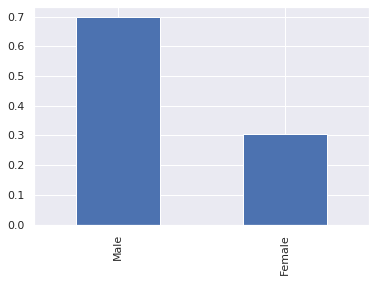

In [6]:
# plot the bar graph customer gender
df_customers.customer_gender_female.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Male", "Female"]);

The dataset is heavily weighted towards male customers.

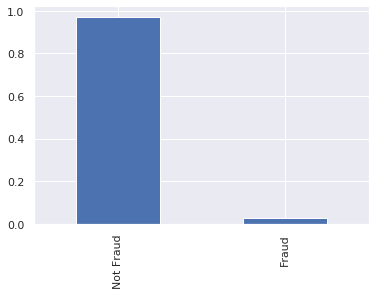

In [4]:
# plot the bar graph of fraudulent claims
df_claims.fraud.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Not Fraud", "Fraud"]);

The overwhemling majority of claims are legitimate (i.e. not fraudulent).

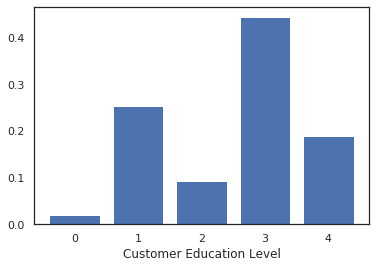

In [15]:
# plot the education categories
educ = df_customers.customer_education.value_counts(normalize=True, sort=False)
plt.bar(educ.index, educ.values)
plt.xlabel("Customer Education Level");

Text(0.5, 0, 'Total Claim Amount')

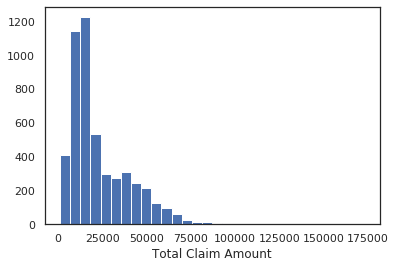

In [9]:
# plot the total claim amounts
plt.hist(df_claims.total_claim_amount, bins=30)
plt.xlabel("Total Claim Amount")

Majority of the total claim amounts are under $25,000.

Text(0.5, 0, 'Number of claims per year')

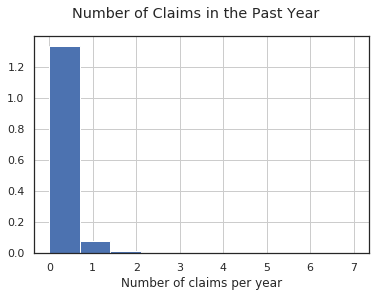

In [10]:
# plot the number of claims filed in the past year
df_customers.num_claims_past_year.hist(density=True)
plt.suptitle("Number of Claims in the Past Year")
plt.xlabel("Number of claims per year")

Most customers did not file any claims in the previous year, but some filed as many as 7 claims.

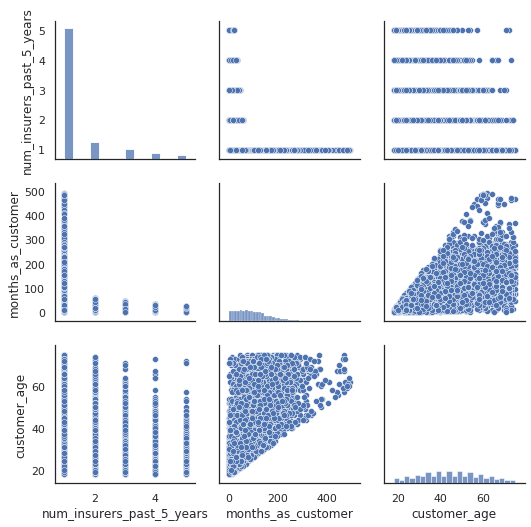

In [11]:
sns.pairplot(
    data=df_customers, vars=["num_insurers_past_5_years", "months_as_customer", "customer_age"]
);

Understandably, the `months_as_customer` and `customer_age` are correlated with each other. A younger person have been driving for a smaller amount of time and therefore have a smaller potential for how long they might have been a customer.

We can also see that the `num_insurers_past_5_years` is negatively correlated with `months_as_customer`. If someone frequently jumped around to different insurers, then they probably spent less time as a customer of this insurer.

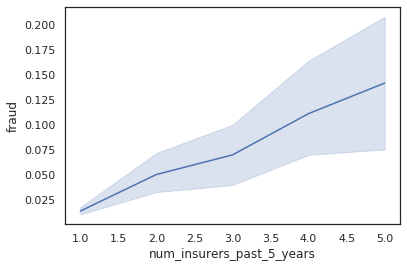

In [16]:
df_combined = df_customers.join(df_claims)
sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_combined);

Fraud is positively correlated with having a greater number of insurers over the past 5 years. Customers who switched insurers more frequently also had more prevelance of fraud.

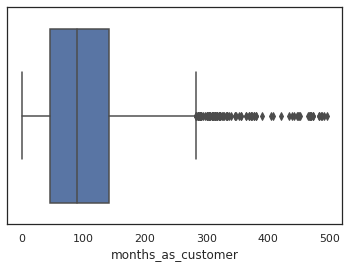

In [17]:
sns.boxplot(x=df_customers["months_as_customer"]);

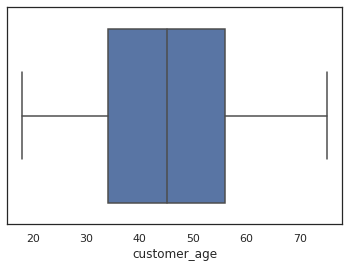

In [18]:
sns.boxplot(x=df_customers["customer_age"]);

Our customers range from 18 to 75 years old. 

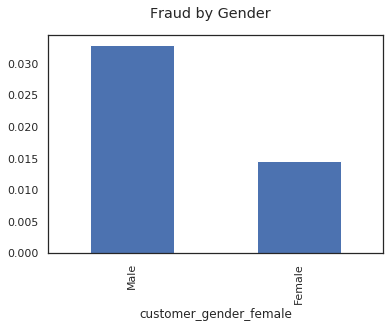

In [19]:
df_combined.groupby("customer_gender_female").mean()["fraud"].plot.bar()
plt.xticks([0, 1], ["Male", "Female"])
plt.suptitle("Fraud by Gender");

Fraudulent claims come disproportionately from male customers.

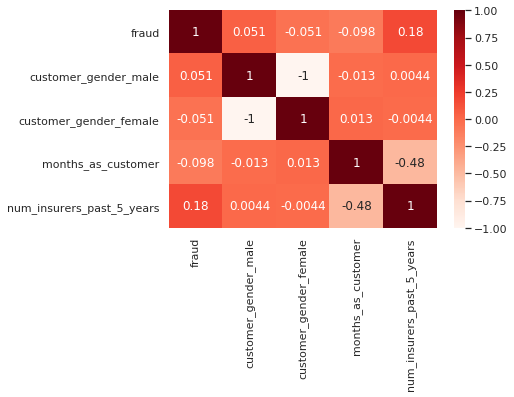

In [20]:
# Creating a correlation matrix of fraud, gender, months as customer, and number of different insurers
cols = [
    "fraud",
    "customer_gender_male",
    "customer_gender_female",
    "months_as_customer",
    "num_insurers_past_5_years",
]
corr = df_combined[cols].corr()

# plot the correlation matrix
sns.heatmap(corr, annot=True, cmap="Reds");

Fraud is correlated with having more insurers in the past 5 years, and negatively correlated with being a customer for a longer period of time. These go hand in hand and mean that long time customers are less likely to commit fraud.

### Combined DataSets

We have been looking at the indivudual datasets, now let's look at their combined view (join).

In [21]:
import pandas as pd

df_combined = pd.read_csv("./data/claims_customer.csv")

In [22]:
df_combined = df_combined.loc[:, ~df_combined.columns.str.contains("^Unnamed: 0")]
# get rid of an unwanted column
df_combined.head()

,policy_id,incident_type_breakin,num_vehicles_involved,collision_type_na,policy_state_nv,authorities_contacted_fire,customer_gender_male,authorities_contacted_ambulance,injury_claim,policy_deductable,...,customer_age,collision_type_side,driver_relationship_child,police_report_available,policy_state_wa,incident_severity,customer_education,policy_liability,policy_state_id,num_injuries
0,217,1,1,1,0,0,1,0,9000.0,750,...,52,0,0,0,0,1,3,3,0,1
1,1954,0,3,0,0,0,1,0,17500.0,750,...,28,0,0,1,0,2,1,0,0,4
2,2114,0,3,0,0,0,1,0,32500.0,750,...,39,0,0,1,0,1,3,1,0,3
3,3813,1,1,1,0,0,1,0,0.0,750,...,66,0,0,0,0,0,2,0,0,0
4,553,0,2,0,0,0,0,0,74000.0,750,...,39,1,0,0,0,1,4,3,0,3


In [23]:
df_combined.describe()

,policy_id,incident_type_breakin,num_vehicles_involved,collision_type_na,policy_state_nv,authorities_contacted_fire,customer_gender_male,authorities_contacted_ambulance,injury_claim,policy_deductable,...,customer_age,collision_type_side,driver_relationship_child,police_report_available,policy_state_wa,incident_severity,customer_education,policy_liability,policy_state_id,num_injuries
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,2500.500000,0.092400,2.124800,0.140000,0.05100,0.029000,0.696800,0.021800,5406.100000,751.200000,...,45.085400,0.210200,0.045000,0.434000,0.120600,0.831000,2.529400,1.112200,0.02760,0.560200
std,1443.520003,0.289619,0.839146,0.347022,0.22002,0.167823,0.459687,0.146045,10758.326129,13.660063,...,14.290254,0.407491,0.207325,0.495674,0.325694,0.794333,1.119547,0.997101,0.16384,1.007859
min,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,750.000000,...,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1250.750000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,750.000000,...,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
50%,2500.500000,0.000000,2.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,750.000000,...,45.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.00000,0.000000
75%,3750.250000,0.000000,3.000000,0.000000,0.00000,0.000000,1.000000,0.000000,7500.000000,750.000000,...,56.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,2.000000,0.00000,1.000000
max,5000.000000,1.000000,7.000000,1.000000,1.00000,1.000000,1.000000,1.000000,158000.000000,1100.000000,...,75.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,3.000000,1.00000,4.000000


Let's explore any unique, missing, or large percentage category in the combined dataset.

In [24]:
combined_stats = []


for col in df_combined.columns:
    combined_stats.append(
        (
            col,
            df_combined[col].nunique(),
            df_combined[col].isnull().sum() * 100 / df_combined.shape[0],
            df_combined[col].value_counts(normalize=True, dropna=False).values[0] * 100,
            df_combined[col].dtype,
        )
    )

stats_df = pd.DataFrame(
    combined_stats,
    columns=["feature", "unique_values", "percent_missing", "percent_largest_category", "datatype"],
)
stats_df.sort_values("percent_largest_category", ascending=False)

,feature,unique_values,percent_missing,percent_largest_category,datatype
9,policy_deductable,7,0.0,98.88,int64
7,authorities_contacted_ambulance,2,0.0,97.82,int64
13,fraud,2,0.0,97.28,int64
45,policy_state_id,2,0.0,97.24,int64
5,authorities_contacted_fire,2,0.0,97.10,int64
23,driver_relationship_other,2,0.0,96.12,int64
39,driver_relationship_child,2,0.0,95.50,int64
27,incident_type_theft,2,0.0,95.24,int64
4,policy_state_nv,2,0.0,94.90,int64
22,num_claims_past_year,8,0.0,93.26,int64


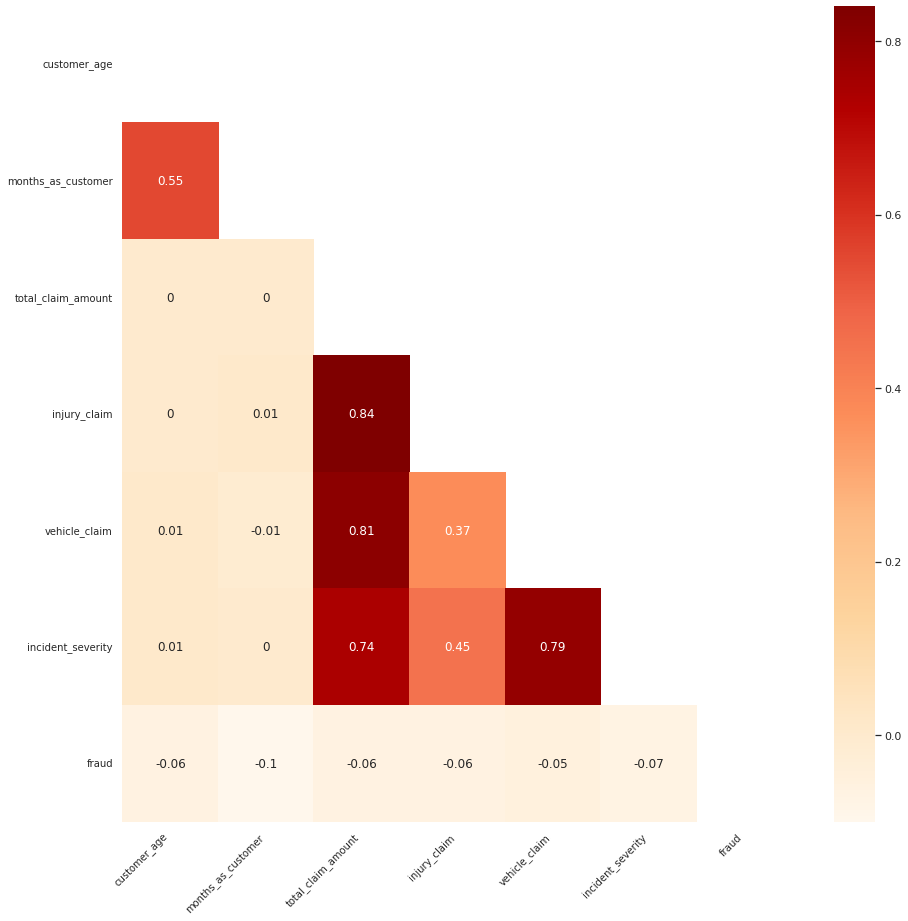

In [25]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("white")

corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity",
    "fraud",
]

corr_df = df_combined[corr_list]
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(15, 15))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="OrRd")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

___

### Next Notebook: [Data Preparation, Data Wrangler, Feature Store](./03-DataPrep-Wrangler-FeatureStore.ipynb)